In [9]:
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, AncillaRegister
from qiskit.quantum_info import Statevector
import scipy.linalg as sl
from qiskit.circuit.library import UnitaryGate, PhaseEstimation
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

Presentemos la aplicación de QPCA mediante un ejemplo práctico para 3 qubits y con los dos siguientes conjuntos:

In [2]:
nqubits=3
conjuntoA=[[1,0,0,0,0,0,0,0],[1/np.sqrt(2),0,0,0,0,0,0,1/np.sqrt(2)]]
conjuntoB=[[0,1,0,0,0,0,0,0],[0,0,0,0,0,0,0,1]]

Implementemos el circuito necesario. Construyamos las matrices de densidad:

In [3]:
m=len(conjuntoA)
rho=(1/m)*sum([np.matrix(conjuntoA[i]).getH()@np.matrix(conjuntoA[i]) for i in range(m)])
sigma=(1/m)*sum([np.matrix(conjuntoB[i]).getH()@np.matrix(conjuntoB[i]) for i in range(m)])

La matriz (y su correspondiente circuito equivalente) sobre la cuál se aplicará la QPE es la siguiente:

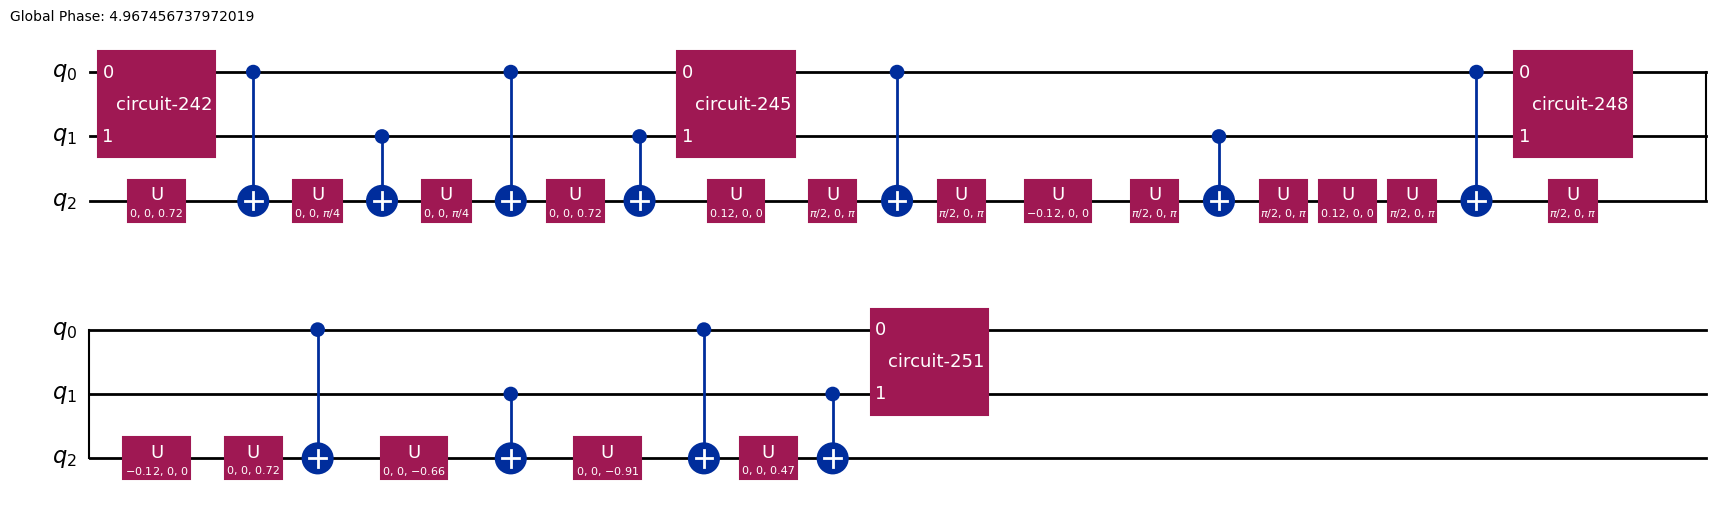

In [4]:
U=sl.expm(1j*(rho-sigma))
gate=UnitaryGate(U)
qc=QuantumCircuit(nqubits)
qc.append(gate,range(nqubits))
qc.decompose().draw('mpl')

Con esto, el circuito que aplicamos para obtener la descomposición en autovalores es el siguiente (con $s$ bits de precisión para la QPE):

In [21]:
s=6
qpe=QuantumCircuit(nqubits+s,s)
qpe=qpe.compose(PhaseEstimation(s,qc))
# Añadimos una capa de swaps, ya que el PhaseEstimation nos devuelve los qubits en orden contrario al usual
for i in range(int(np.floor(s/2))):
    qpe.swap(i,s-i-1)
# Añadimos las medidas que nos revelarán el autovalor.
for n in range(s):
    qpe.measure(n,n)

Así, ya tenemos todo lo necesario. Empecemos aplicando el método sobre el primer estado del conjunto B.

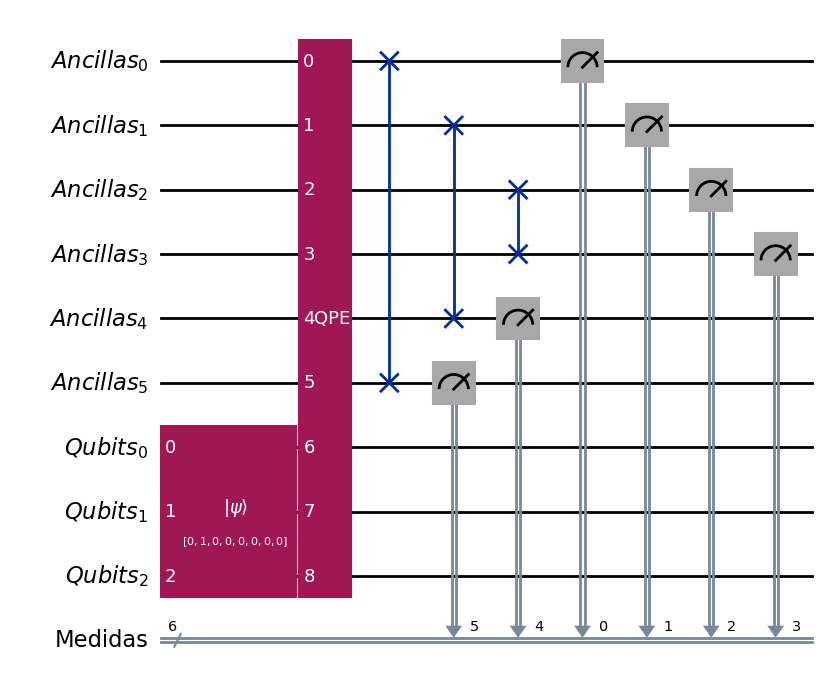

In [26]:
qr = QuantumRegister(nqubits, 'Qubits')
qr_anc = AncillaRegister(s, 'Ancillas')
clr=ClassicalRegister(s,'Medidas')
qpca=QuantumCircuit(qr_anc,qr,clr)
qpca.initialize(conjuntoB[0],qr)
qpca=qpca.compose(qpe)
qpca.draw('mpl')

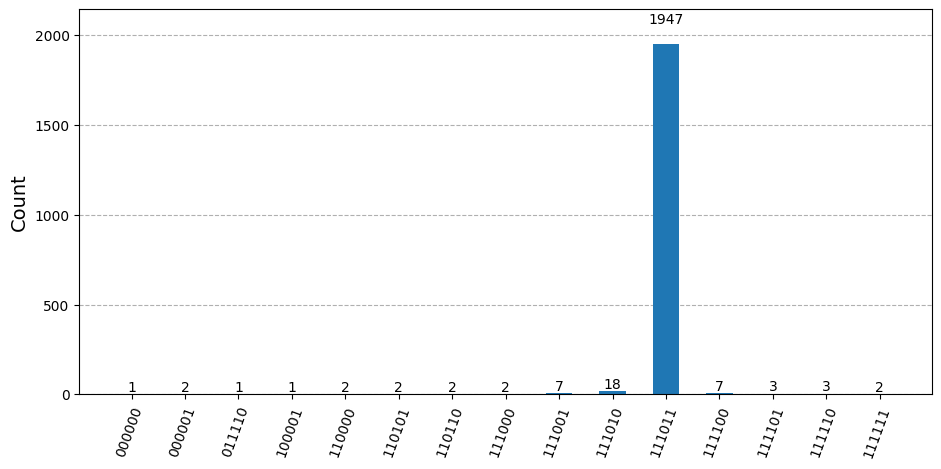

In [27]:
sim = AerSimulator()
shots = 2000
results=sim.run(qpca.decompose().decompose().decompose().decompose(),shots=shots).result()
answer = results.get_counts()
display(plot_histogram(answer, figsize=(11,5)))

Tenemos que nuestra simulación con casi toda probabilidad nos devuelve el valor '111011', es decir, el número 59. Por lo tanto, el autovalor es aproximadamente $2\pi\cdot59/2^6=1.84375\pi$, o, equivalentemente, $-0.15625\pi$. Así, el autovalor es negativo, lo que nos dice que el método asigna este estado al segundo conjunto, como era de esperar.

Probemos ahora a ejecutar el método con el segundo autovalor del conjunto A.

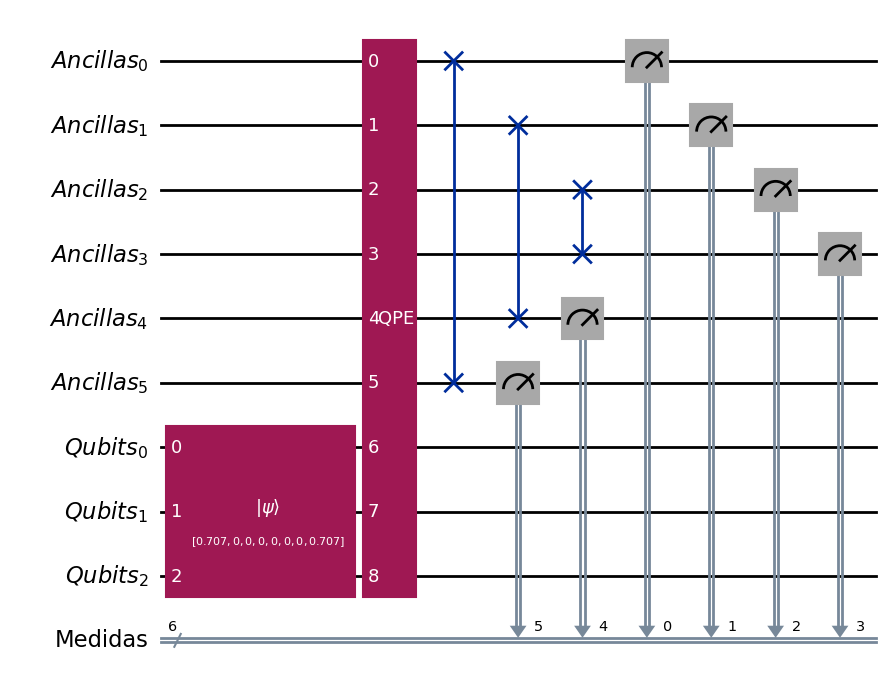

In [28]:
qr = QuantumRegister(nqubits, 'Qubits')
qr_anc = AncillaRegister(s, 'Ancillas')
clr=ClassicalRegister(s,'Medidas')
qpca=QuantumCircuit(qr_anc,qr,clr)
qpca.initialize(conjuntoA[1],qr)
qpca=qpca.compose(qpe)
qpca.draw('mpl')

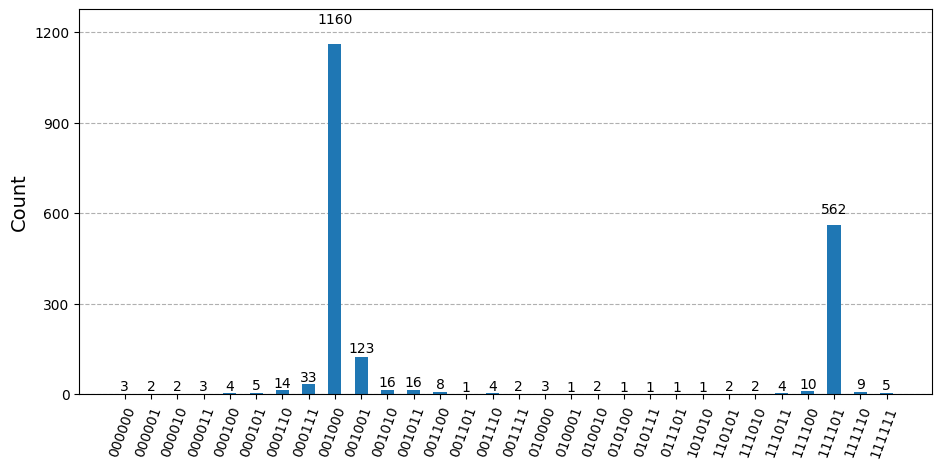

In [29]:
sim = AerSimulator()
shots = 2000
results=sim.run(qpca.decompose().decompose().decompose().decompose(),shots=shots).result()
answer = results.get_counts()
display(plot_histogram(answer, figsize=(11,5)))

En este caso tenemos dos posibles resultados: $2\pi\cdot8/2^6=0.25\pi$ o $2\pi\cdot61/2^6=1.90625\pi\equiv 0.09375\pi$. Así, parece que el método puede asignarnos el estado a ambos conjuntos. Esto se debe a que el estado no es ortogonal al segundo estado del conjunto B.